# Scale-dependent Bias Modification

Initiate notebook.

In [1]:
import os
import pprint

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
from nbodykit.lab import cosmology

## Base cosmological model

In [2]:
FIDUCIAL_COSMOLOGY = cosmology.Planck15
FIDUCIAL_REDSHIFT = 2.

transfer_function = cosmology.power.transfers.CLASS(FIDUCIAL_COSMOLOGY, FIDUCIAL_REDSHIFT)
matter_power_spectrum = cosmology.LinearPower(FIDUCIAL_COSMOLOGY, FIDUCIAL_REDSHIFT)
growth_rate = FIDUCIAL_COSMOLOGY.scale_independent_growth_rate(FIDUCIAL_REDSHIFT)

In [3]:
def scale_modification(redshift, cosmo=FIDUCIAL_COSMOLOGY):
    """Return the scale-dependence modification as a function of redshift.

    Parameters
    ----------
    redshift : float
        Redshift.
    cosmo : :class:`nbodykit.cosmology.Cosmology`, optional
        Base cosmological model (default is ``nbodykit.cosmology.Planck15``).

    Returns
    -------
    callable
        Scale-dependence modification as a function of the Fourier scale (in h/Mpc).

    """
    SPHERICAL_COLLAPSE_CRITICAL_OVERDENSITY = 1.686
    SPEED_OF_LIGHT_IN_HUNDRED_KM_PER_S = 2998.

    num_factors = 3 * (cosmo.h / SPEED_OF_LIGHT_IN_HUNDRED_KM_PER_S)**2 * SPHERICAL_COLLAPSE_CRITICAL_OVERDENSITY * cosmo.Omega0_m
    transfer_func = cosmology.power.transfers.CLASS(cosmo, redshift=redshift)

    return lambda k: num_factors / (k**2 * transfer_func(k))

In [4]:
def general_relativistic_correction(evolution_bias, magnification_bias, cosmo=FIDUCIAL_COSMOLOGY):
    """Return the general relativistic correction as a function of redshift.

    Parameters
    ----------
    evolution_bias, magnification_bias : callable
        Evolution bias or magnification bias as a function of redshift.
    cosmo : :class:`nbodykit.cosmology.Cosmology`, optional
        Base cosmological model (default is ``nbodykit.cosmology.Planck15``).

    Returns
    -------
    callable
        General relativistic correction as a function of redshift.

    """
    pass

## Non-Gaussianity signature only

In [4]:
modif_NG = lambda k: param_NG * (1 - 1/BIAS) * poisson_kernel(k) / k**2

In [5]:
poles_NG = {
    '0': lambda k: (1 + 2/3*beta + 1/5*beta**2 + (2+2/3*beta) * modif_NG(k) + modif_NG(k)**2) * BIAS**2 * matter_power(k),
    '2': lambda k: (4/3*beta + 4/7*beta**2 + 4/3*beta * modif_NG(k)) * BIAS**2 * matter_power(k),
    '4': lambda k: 8/35*beta**2 * BIAS**2 * matter_power(k),
    }

## Source evolution signature only

In [6]:
modif_EV = lambda k: param_EV**2 / k**2

In [7]:
poles_EV = {
    '0': lambda k: (1 + 2/3*beta + 1/5*beta**2 + 1/3*beta**2 * modif_EV(k)) * BIAS**2 * matter_power(k),
    '2': lambda k: (4/3*beta + 4/7*beta**2 + 2/3*beta**2 * modif_EV(k)) * BIAS**2 * matter_power(k),
    '4': lambda k: 8/35*beta**2 * BIAS**2 * matter_power(k),
    }

## Both signatures and neither

In [8]:
poles_both = {
    '0': lambda k: (1 + 2/3*beta + 1/5*beta**2 + (2+2/3*beta) * modif_NG(k) + modif_NG(k)**2 + 1/3*beta**2 * modif_EV(k)) * BIAS**2 * matter_power(k),
    '2': lambda k: (4/3*beta + 4/7*beta**2 + 4/3*beta * modif_NG(k) + 2/3*beta**2 * modif_EV(k)) * BIAS**2 * matter_power(k),
    '4': lambda k: 8/35*beta**2 * BIAS**2 * matter_power(k),
    }

poles_none = {
    '0': lambda k: (1 + 2/3*beta + 1/5*beta**2) * BIAS**2 * matter_power(k),
    '2': lambda k: (4/3*beta + 4/7*beta**2) * BIAS**2 * matter_power(k),
    '4': lambda k: 8/35*beta**2 * BIAS**2 * matter_power(k),
    }

## Comparison

In [9]:
k = np.logspace(np.log10(KMIN), np.log10(KMAX), 100)

In [10]:
cs = {'NG': 'blue', 'EV': 'green', 'both': 'red', 'none': 'k'}
ls = {'0': '-', '2': '--'}

plt.rc('font', family='serif')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.close('all')

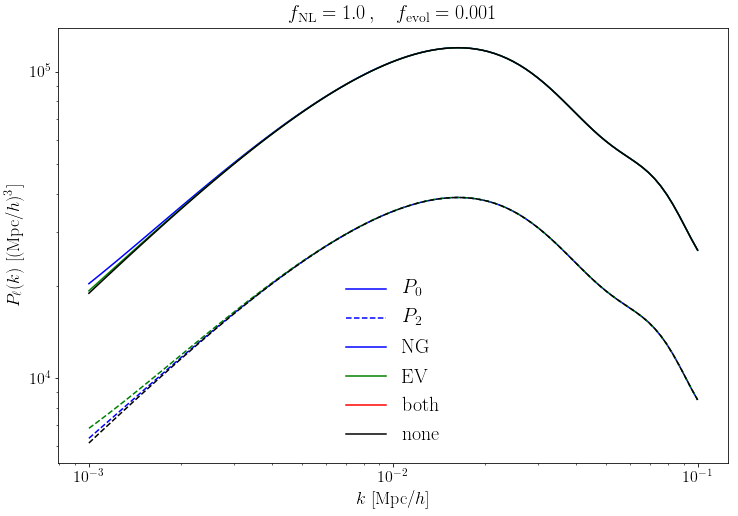

In [11]:
plt.figure('Signature comparison', figsize=(12, 8))

for ell in [0, 2,]:
    plt.plot(k, poles_NG[f'{ell}'](k), c=cs['NG'], ls=ls[f'{ell}'], label=r'$P_{}$'.format(ell))
    plt.plot(k, poles_EV[f'{ell}'](k), c=cs['EV'], ls=ls[f'{ell}'])
    plt.plot(k, poles_none[f'{ell}'](k), c=cs['none'], ls=ls[f'{ell}'])

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$ [Mpc/$h$]', fontsize=18)
plt.ylabel(r'$P_\ell(k)$ [$($Mpc/$h$$)^3$]', fontsize=18)

handles, labels = plt.gca().get_legend_handles_labels()
handles.extend(
    [Line2D([0], [0], color=val) for _, val in cs.items()]
    )
labels.extend(
    [key for key, _ in cs.items()]
    )
plt.legend(handles, labels, frameon=False, fontsize=20)

plt.title(
    r'$f_{{\mathrm{{NL}}}} = {{{}}}\,, \quad f_{{\mathrm{{evol}}}} = {{{}}}$'.format(param_NG, param_EV),
    fontsize=20
    )
plt.savefig('Signature_comparison.pdf', format='pdf')

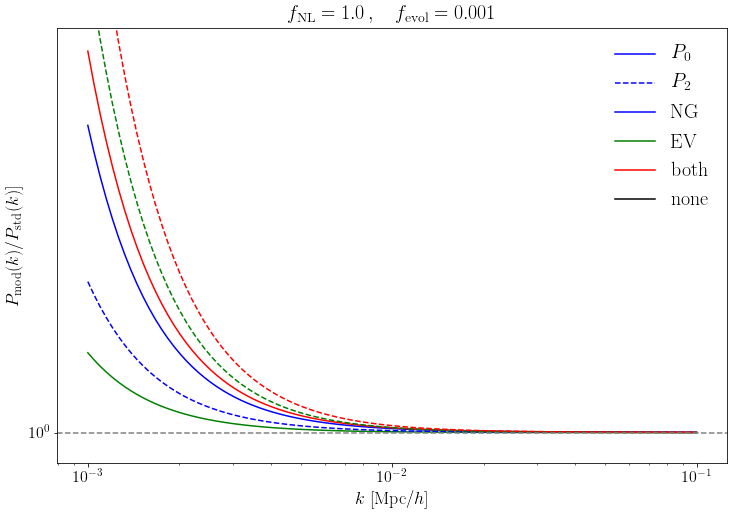

In [12]:
plt.figure('Signature ratio', figsize=(12, 8))

for ell in [0, 2,]:
    plt.loglog(k, poles_NG[f'{ell}'](k)/poles_none[f'{ell}'](k), c=cs['NG'], ls=ls[f'{ell}'], label=r'$P_{}$'.format(ell))
    plt.loglog(k, poles_EV[f'{ell}'](k)/poles_none[f'{ell}'](k), c=cs['EV'], ls=ls[f'{ell}'])
    plt.semilogx(k, poles_both[f'{ell}'](k)/poles_none[f'{ell}'](k), c=cs['both'], ls=ls[f'{ell}'])

plt.axhline(y=1, ls='--', c='gray')
plt.xlabel(r'$k$ [Mpc/$h$]', fontsize=18)
plt.ylabel(r'$P_{{\mathrm{{mod}}}}(k) / P_{{\mathrm{{std}}}}(k)$]', fontsize=18)
plt.ylim(top=1.1)
plt.yscale('log')

handles, labels = plt.gca().get_legend_handles_labels()
handles.extend(
    [Line2D([0], [0], color=val) for _, val in cs.items()]
    )
labels.extend(
    [key for key, _ in cs.items()]
    )
plt.legend(handles, labels, frameon=False, fontsize=20)

plt.title(
    r'$f_{{\mathrm{{NL}}}} = {{{}}}\,, \quad f_{{\mathrm{{evol}}}} = {{{}}}$'.format(param_NG, param_EV),
    fontsize=20
    )
plt.savefig('Signature_ratio.pdf', format='pdf')